In [ ]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
from tqdm import tqdm
from sklearn import metrics
from sklearn.model_selection import train_test_split

import torch
from torch import nn, optim
import torch.nn.functional as F
from torchvision import transforms
from torchvision.datasets import SVHN
from torch.utils.data import DataLoader
from torch.utils.data import random_split

In [ ]:
transform = transforms.Compose(
    [  
        transforms.Resize((224, 224)), 
        transforms.RandomCrop((224, 224)),  
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.5), 
        transforms.RandomRotation(degrees=45),  
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.05),  
        transforms.RandomGrayscale(p=0.2),  
        transforms.ToTensor(),  
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),  
    ]
)
dataset = SVHN(root='data/', download=True, transform=transform)

Using downloaded and verified file: data/train_32x32.mat


In [ ]:
test_size = 12000
train_size = len(dataset) - test_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
len(train_dataset), len(test_dataset)

(61257, 12000)

In [ ]:
batch_size = 32
train_data_loader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=0, pin_memory=False)
test_data_loader = DataLoader(test_dataset, batch_size, num_workers=0, pin_memory=False)

In [ ]:
class Alexnet(nn.Module):
    def __init__(self, in_channels=3):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=96, kernel_size=11, stride=4, padding=0)
        self.conv2 = nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, stride=1, padding=2)

        self.conv3 = nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.flatten = nn.Flatten()
        
        self.dense1 = nn.Linear(256*5*5, 4096)
        self.dense2 = nn.Linear(4096, 4096)
        self.dense3 = nn.Linear(4096, 10)

        self.max_pool = nn.MaxPool2d(kernel_size=3, stride=2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.max_pool(self.relu(self.conv1(x)))
        x = self.max_pool(self.relu(self.conv2(x)))

        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))
        x = self.max_pool(self.relu(self.conv5(x)))
        x = self.flatten(x)

        x = self.dropout(self.relu(self.dense1(x)))
        x = self.dropout(self.relu(self.dense2(x)))
        x = self.dense3(x)
        return x

In [ ]:
def train(train_data_loader, model, criterion, optimizer, epoch):
    model.train()
    losses = []

    train_progress_bar = tqdm(enumerate(train_data_loader), total=len(train_data_loader), leave=True)
    for batch_idx, (imgs, labels) in train_progress_bar:
        imgs = imgs.to(DEVICE)
        labels = labels.to(DEVICE)
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_progress_bar.set_description(f"Epoch [{epoch}/{epochs-1}]")
        train_progress_bar.set_postfix(train_loss=loss.item())
        losses.append(loss.item())
        
    train_progress_bar.close()
    return sum(losses) / len(losses)

def evaluate(test_data_loader, model, criterion):
    model.eval()
    losses = []
    predictions = []
    targets = []

    test_progress_bar = tqdm(enumerate(test_data_loader), total=len(test_data_loader), leave=True)
    for _, (imgs, labels) in test_progress_bar:
        imgs = imgs.to(device=DEVICE)
        labels = labels.to(DEVICE)

        with torch.no_grad():
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            losses.append(loss.item())

        predictions.append(torch.softmax(outputs, dim=1).detach().cpu())
        targets.append(labels.detach().cpu())

    predictions = torch.cat(predictions, dim=0).numpy().argmax(axis=1)
    targets = torch.cat(targets, dim=0).view(-1).numpy()

    accuracy = metrics.accuracy_score(targets, predictions)
    test_progress_bar.close()
    return sum(losses)/len(losses), accuracy

In [ ]:
def save_checkpoint(model, optimizer, filename="model.pth.tar"):
    print("=>Saving Checkpoint...")
    checkpoint = {"state_dict": model.state_dict(), "optimizer": optimizer.state_dict()}
    torch.save(checkpoint, filename)

def load_checkpoint(checkpoint_path, model, optimizer):
    print("=>Loading Checkpoint...")
    checkpoint = torch.load(checkpoint_path, map_location=DEVICE)
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])

In [ ]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LOAD_MODEL = False
learning_rate = 1e-4
weight_decay = 1e-4
epochs = 5

model = Alexnet()
model = model.to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, mode="min", patience=10, verbose=True)

if LOAD_MODEL: 
    load_checkpoint(f"model.pth.tar", model, optimizer)

train_losses, test_losses, train_accuracies, test_accuracies = [], [], [], []
acc = -float("inf")
for epoch in range(epochs):
    train_loss = train(train_data_loader, model, criterion, optimizer, epoch)  
    _, train_accuracy = evaluate(train_data_loader, model, criterion) 
    test_loss, test_accuracy = evaluate(test_data_loader, model, criterion)

    if test_accuracy > acc:
        save_checkpoint(model, optimizer, filename=f"model.h5")
        acc = test_accuracy

    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

    if train_loss - test_loss < 1e-5:
        break

    mean_loss = sum(train_losses)/len(train_losses)
    scheduler.step(mean_loss)
    print(f"Epoch: {epoch}, Loss: {train_loss}, train_accuracy: {train_accuracy}, test_accuracy: {test_accuracy}")

100%|██████████| 375/375 [00:25<00:00, 14.96it/s]


=>Saving Checkpoint...
Epoch: 0, Loss: 1.2818151392840218, train_accuracy: 0.7939990531694336, test_accuracy: 0.79375


100%|██████████| 375/375 [00:25<00:00, 14.78it/s]


=>Saving Checkpoint...
Epoch: 1, Loss: 0.46078089640789494, train_accuracy: 0.8900697063192778, test_accuracy: 0.8831666666666667


100%|██████████| 375/375 [00:25<00:00, 14.56it/s]


=>Saving Checkpoint...
Epoch: 2, Loss: 0.348266400104053, train_accuracy: 0.909887849551888, test_accuracy: 0.9000833333333333


100%|██████████| 375/375 [00:25<00:00, 14.86it/s]


=>Saving Checkpoint...
Epoch: 3, Loss: 0.2950233049953342, train_accuracy: 0.9288734348727492, test_accuracy: 0.9171666666666667


100%|██████████| 375/375 [00:25<00:00, 14.89it/s]


=>Saving Checkpoint...
Epoch: 4, Loss: 0.2556412646780398, train_accuracy: 0.9394028437566319, test_accuracy: 0.9195


In [ ]:
def get_smooth(arr):
    res = []
    s = 0
    for ind, ele in enumerate(arr):
        s += ele
        res.append(s/(ind+1))
    return res

Accuracyrelu is:  0.9195


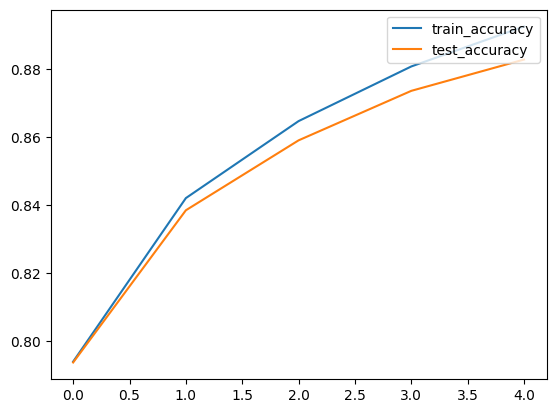

In [ ]:
plt.plot(range(epochs), get_smooth(train_accuracies), label='train_accuracy')
plt.plot(range(epochs), get_smooth(test_accuracies), label='test_accuracy')
plt.legend(loc='upper right')
print("Accuracyrelu is: ", acc)

Accuracyrelu is:  0.9195


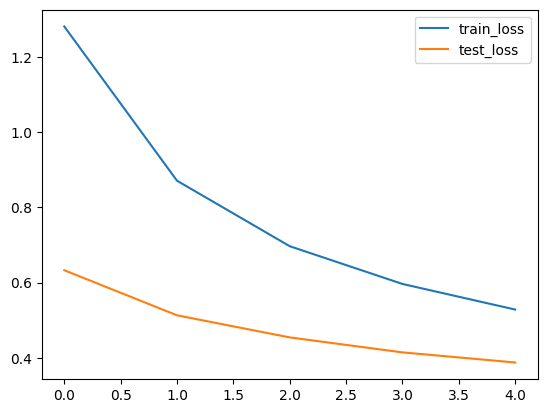

In [ ]:
plt.plot(range(epochs), get_smooth(train_losses), label='train_loss')
plt.plot(range(epochs), get_smooth(test_losses), label='test_loss')
plt.legend(loc='upper right')
print("Accuracyrelu is: ", acc)